# ML Project: Classification 

## Predict what feature has more influence over income 

- Education vs Salary
- Sex vs Salary 

$50K/yr based on census data

Authors:
`Andrea Murphy` and `Josh Quigley`

## Setup

In [1]:
%matplotlib inline
import random

import pandas as pd
from pandas import Series,DataFrame
import numpy as np

import matplotlib.pyplot as plt
from time import time
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [3]:
import pylab as plot
params = { 
    "axes.labelsize": "large",
    "xtick.labelsize" : "x-large",
    "legend.fontsize": 20,
    "figure.dpi": 150,
    "figure.figsize" : [25, 7]
}
plot.rcParams.update(params)

In [4]:
# Import data from https://archive.ics.uci.edu/ml/datasets/Adult 

data = pd.read_csv('data/adult.data.txt')
test_data = pd.read_csv('data/adult.test.txt') 

## Label columns 

In [5]:
data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race",
                           "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


In [6]:
# This dataset has 32,559 records

data.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


In [7]:
data.shape

(32560, 15)

In [8]:
type(data.index)

pandas.core.indexes.range.RangeIndex

In [9]:
# Check to see if there are nulls

data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

# Education (and Age) vs Salary 

In [10]:
# drop columns won't be useful in analysis and prediction
data_education = data.drop(['fnlwgt', 'hours-per-week', 'native-country', 'sex', 'race', 'education', 'relationship', 'occupation', 'marital-status', 'workclass', 'capital-gain', 'capital-loss'], axis=1)

In [11]:
# sample 10000 random entries to train
data_education = data_education.sample(n=10000)

In [12]:
#Let's see what's left
data_education.head()

,age,education-num,salary
23867,77,15,0
6310,37,10,0
31583,40,10,0
3869,24,6,0
14305,28,10,0


In [13]:
data_education.shape

(10000, 3)

In [14]:
# The 3 largest categories are Highschool Graduates (education-num 9),
# Some College Education (education-num 10), and Bachelors Degrees (education-num 13). 

data_education["education-num"].value_counts()

9     3260
10    2249
13    1602
14     528
11     418
7      338
12     336
6      294
4      201
5      174
15     168
16     137
8      127
3      100
2       54
1       14
Name: education-num, dtype: int64

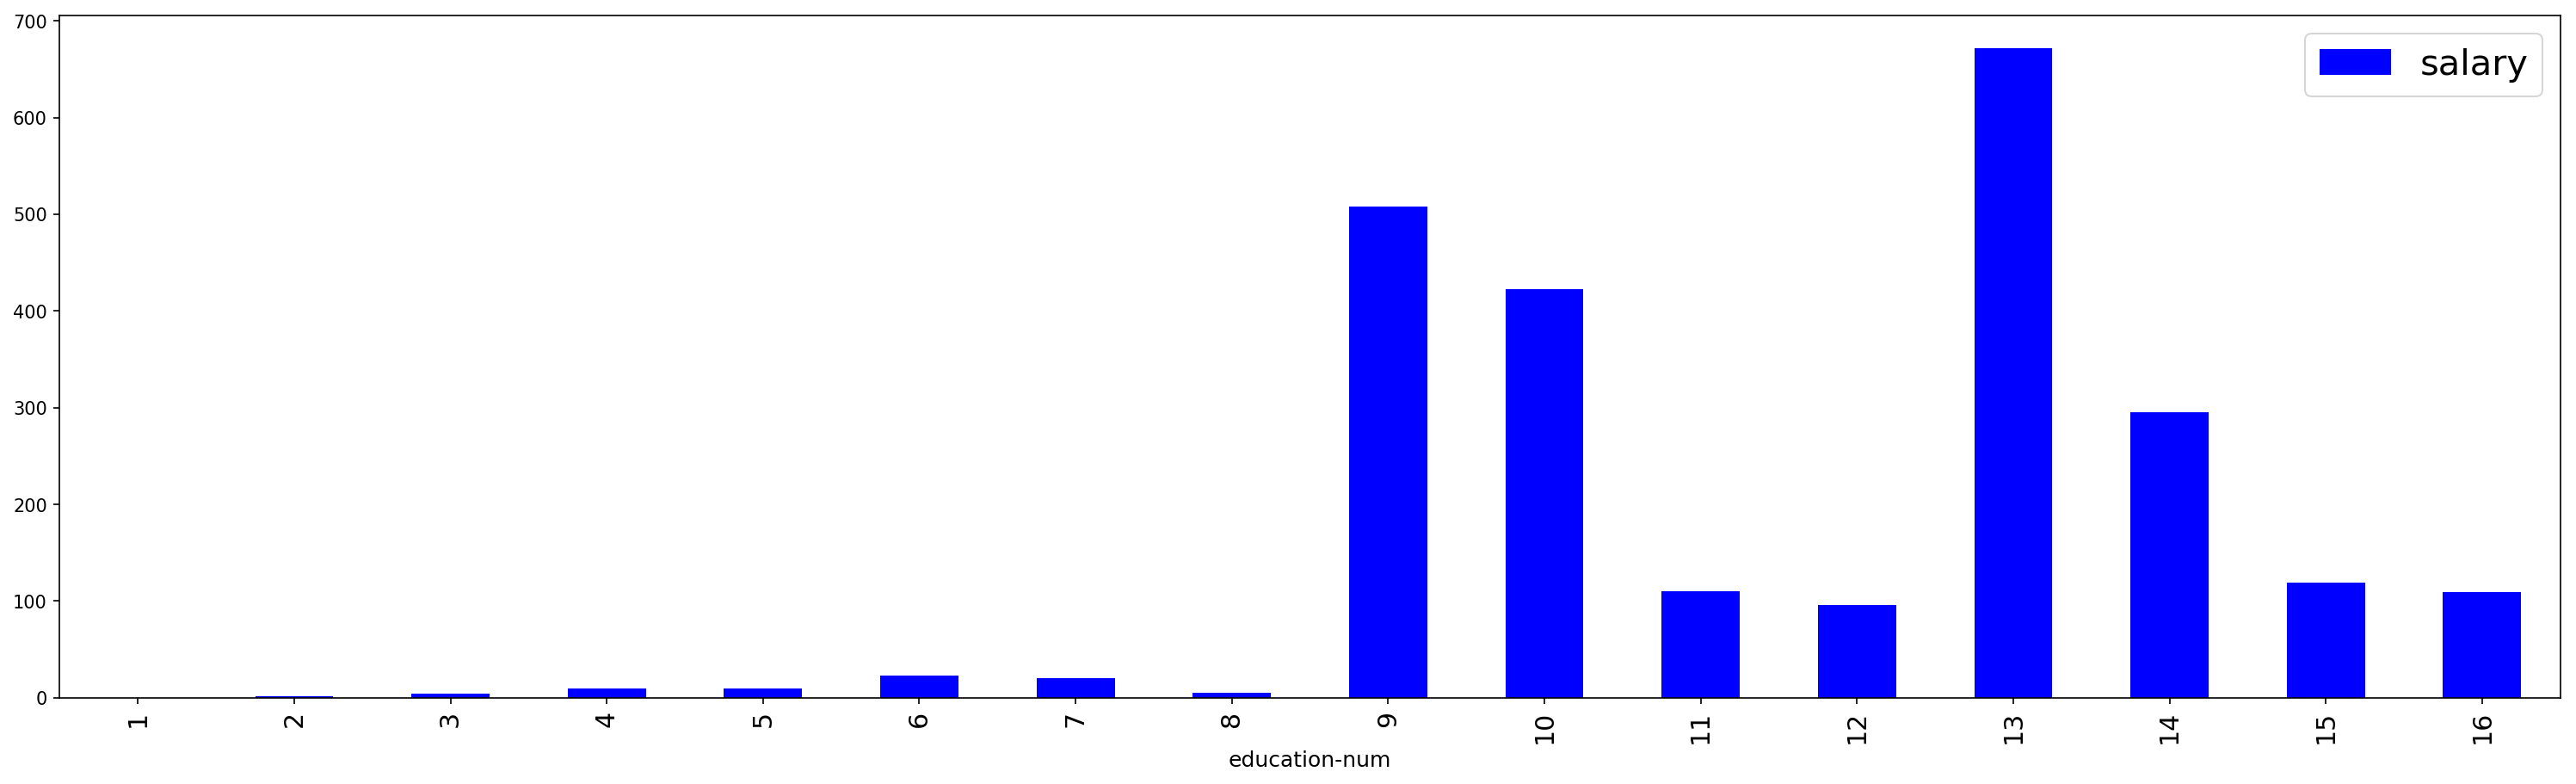

In [15]:
#Bar graph exploring which education groups are making $50,000 or more.

data_education.groupby('education-num').agg('sum')[['salary']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r']);

In [16]:
#X Train and y-train have 70000 records of education-num and age and y-train has 70000 records of salary.
#X Test has 3000 withheld records on education-num and age and y-test has 3000 records of salary.

X_train = data_education.iloc[:7000]
X_train = X_train.drop(['salary'], axis=1)

X_test = data_education.iloc[7000:]
X_test = X_test.drop(['salary'], axis=1)

y_train = data_education.iloc[:7000]
y_train = y_train['salary']

y_test = data_education.iloc[7000:]
y_test = y_test['salary']

## Decision Tree

In [17]:
#Now we train using a Decision Tree Classifier - A model represented as a sequence of branching statements

tree_clf = DecisionTreeClassifier()

In [18]:
# We will time how long it takes to fit the model

start_time = time()
tree_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.01s


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

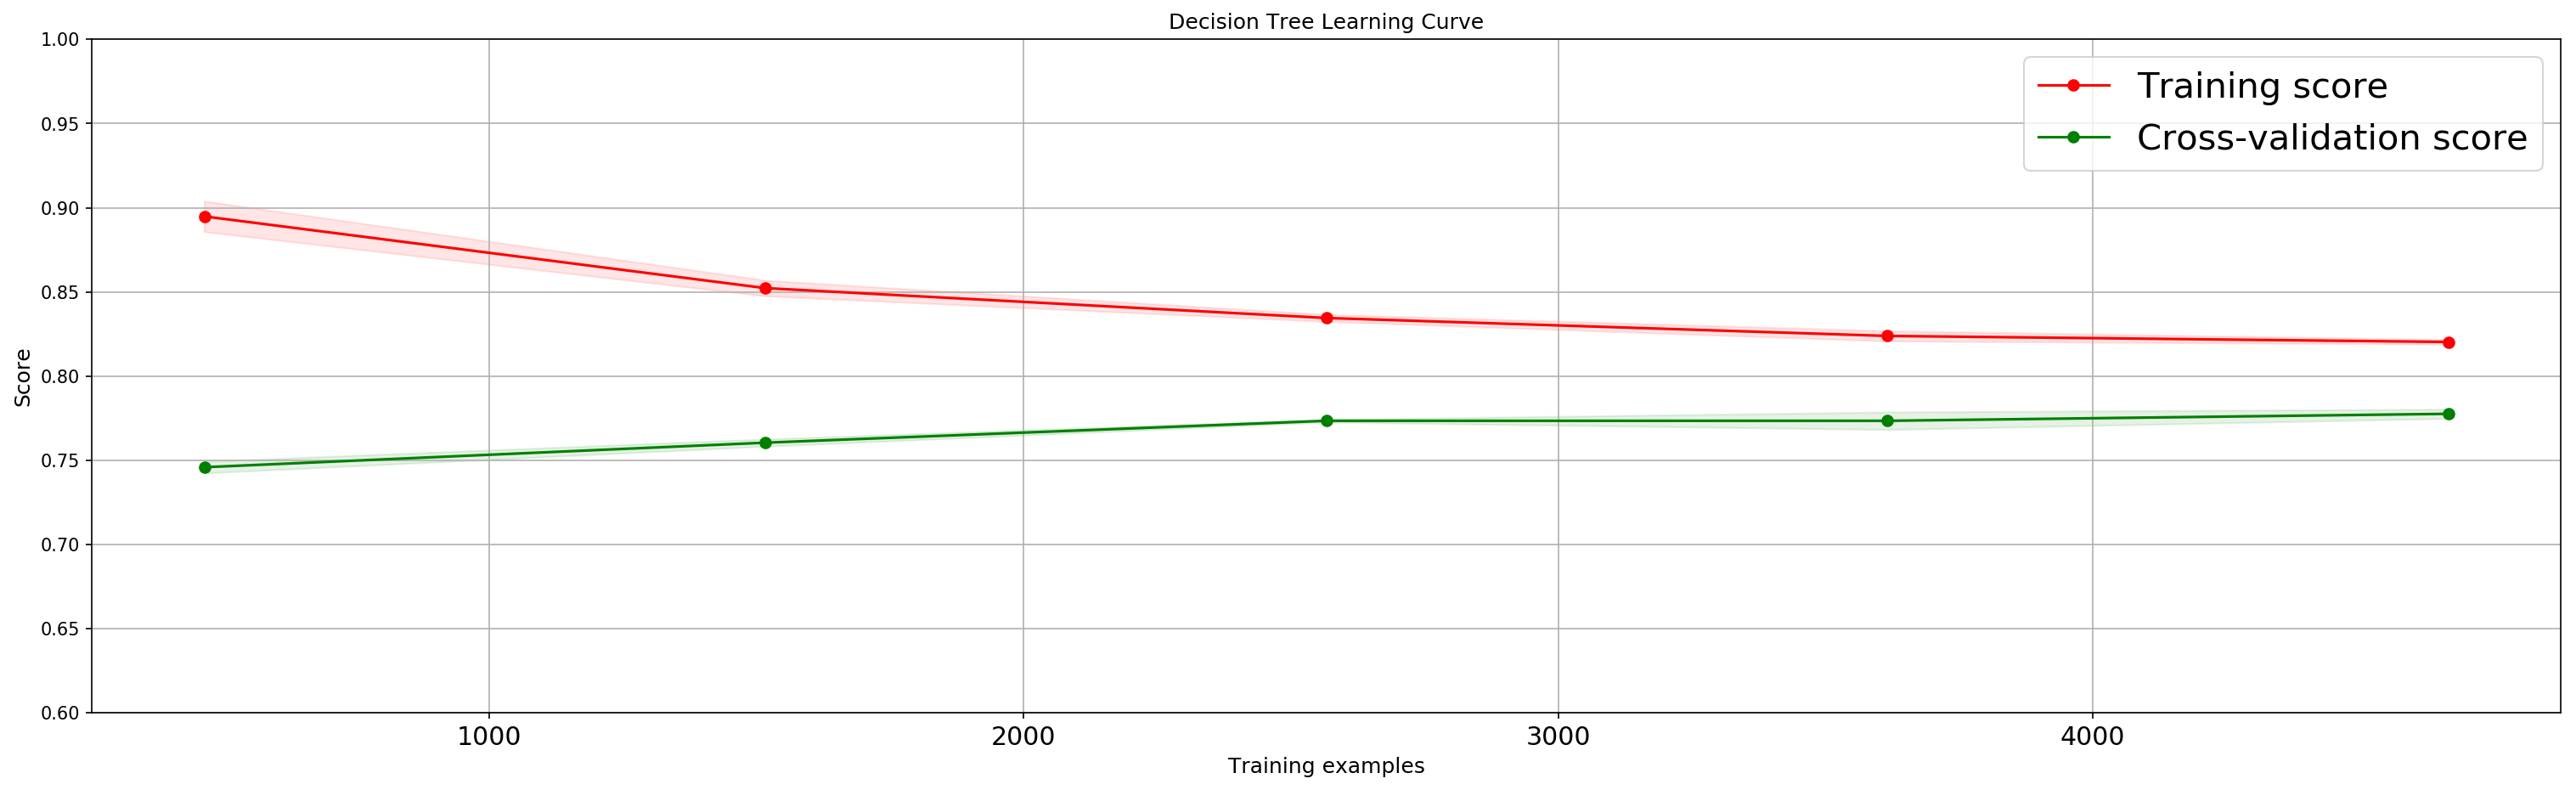

In [19]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(tree_clf, "Decision Tree Learning Curve", X_train, y_train, ylim=(0.6, 1.0), cv=3)   

In [20]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.77977721, 0.77925418, 0.77325332])

In [21]:
y_train_pred_tree_clf = cross_val_predict(tree_clf, X_train, y_train, cv=3)

In [22]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_tree_clf)

array([[4890,  430],
       [1124,  556]])

In [23]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="precision")

array([0.58041958, 0.56838906, 0.54423592])

In [24]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="recall")

array([0.29642857, 0.33392857, 0.3625    ])

## Test Data

In [25]:
y_pred_tree_clf = tree_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

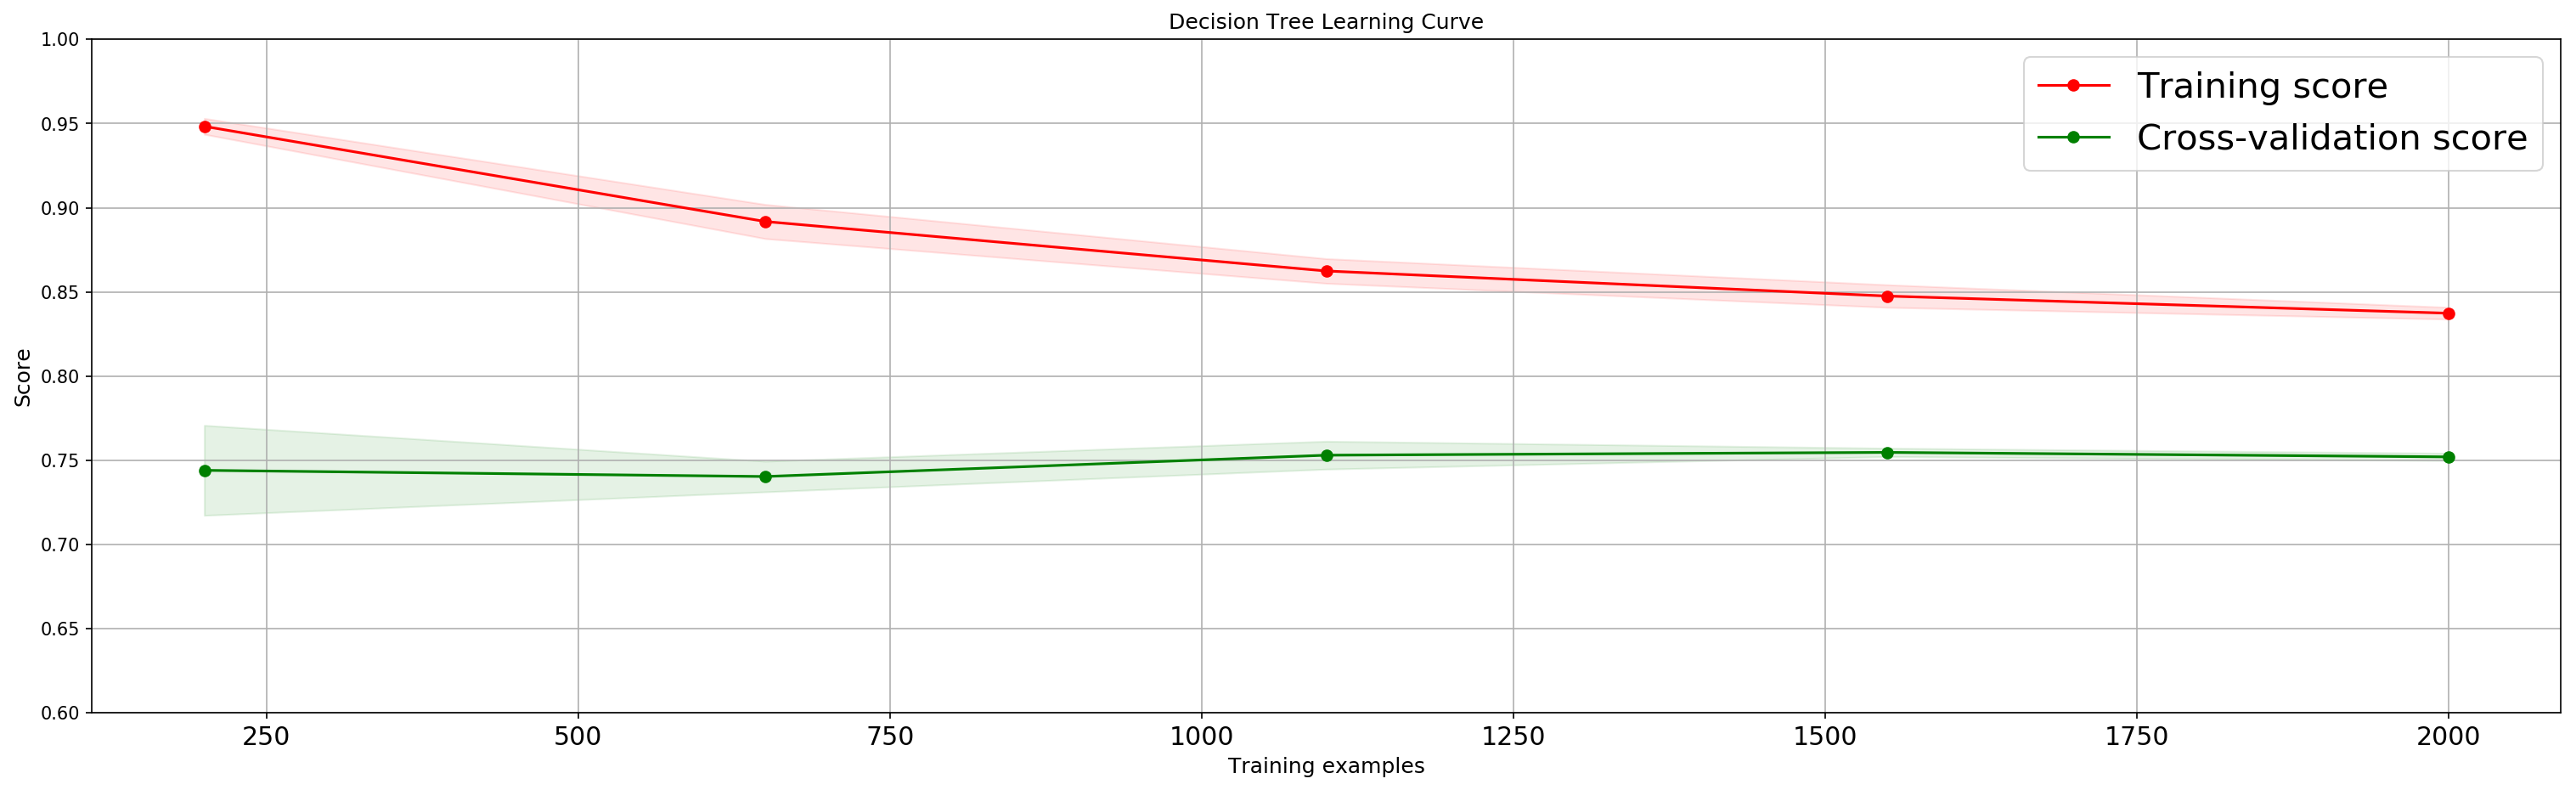

In [26]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(tree_clf, "Decision Tree Learning Curve", X_test, y_test, ylim=(0.6, 1.0), cv=3)   

In [27]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_tree_clf)

array([[2119,  155],
       [ 516,  210]])

In [28]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_tree_clf)

0.5753424657534246

In [29]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_tree_clf)

0.2892561983471074

## Support Vector Machine

In [30]:
# Now we train using a Support Vector Machine - a very powerful and versatile Machine Learning model, 
# capable of performing linear or nonlinear classification

svm_clf = SVC()

In [31]:
# We time how long it takes to fit the model

start_time = time()
svm_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Time elapsed: 0.79s


In [32]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.79434447, 0.78782683, 0.7861123 ])

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

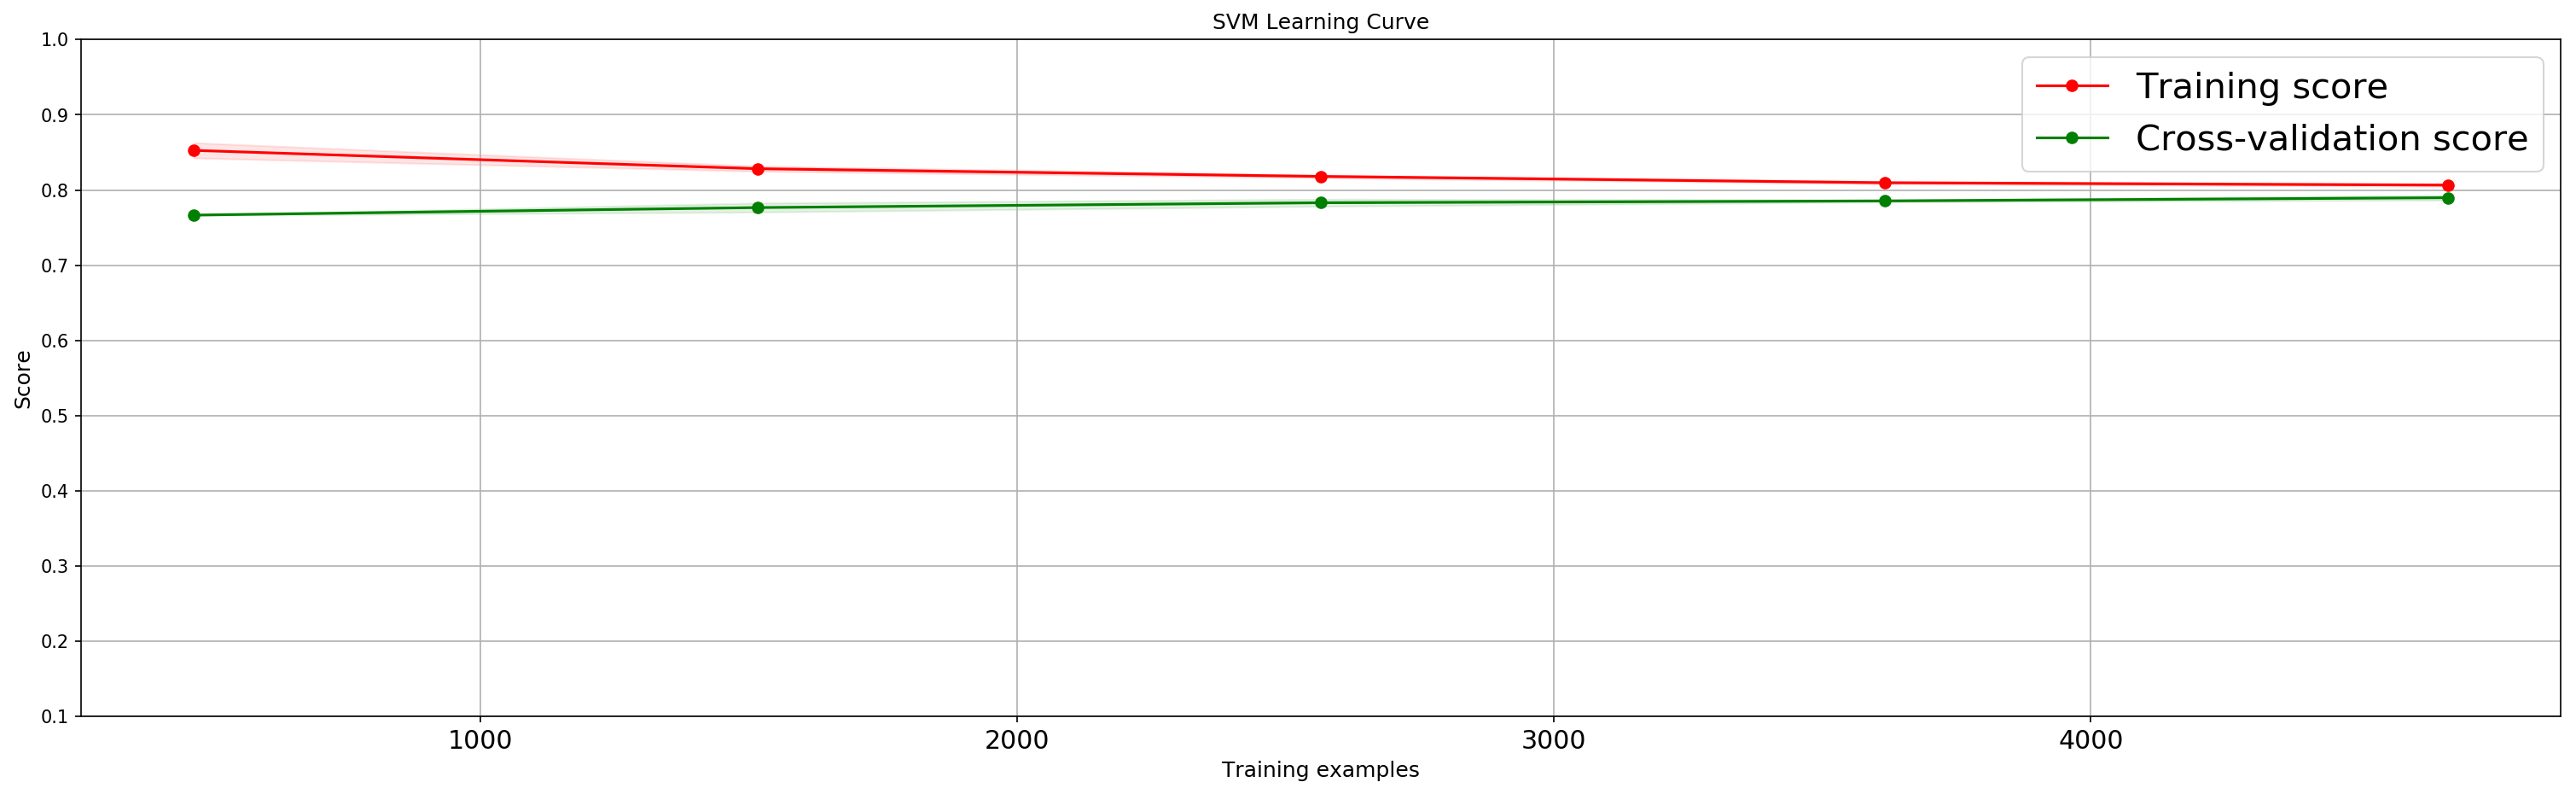

In [33]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(svm_clf, "SVM Learning Curve", X_train, y_train, ylim=(0.1, 1.0), cv=3)    

In [34]:
y_train_pred_svm_clf = cross_val_predict(svm_clf, X_train, y_train, cv=3)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [35]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_svm_clf)

array([[4959,  361],
       [1113,  567]])

In [36]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="precision")

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.63333333, 0.61245675, 0.5899705 ])

In [37]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="recall")

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.33928571, 0.31607143, 0.35714286])

## Test Data

In [38]:
y_pred_svm_clf = svm_clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

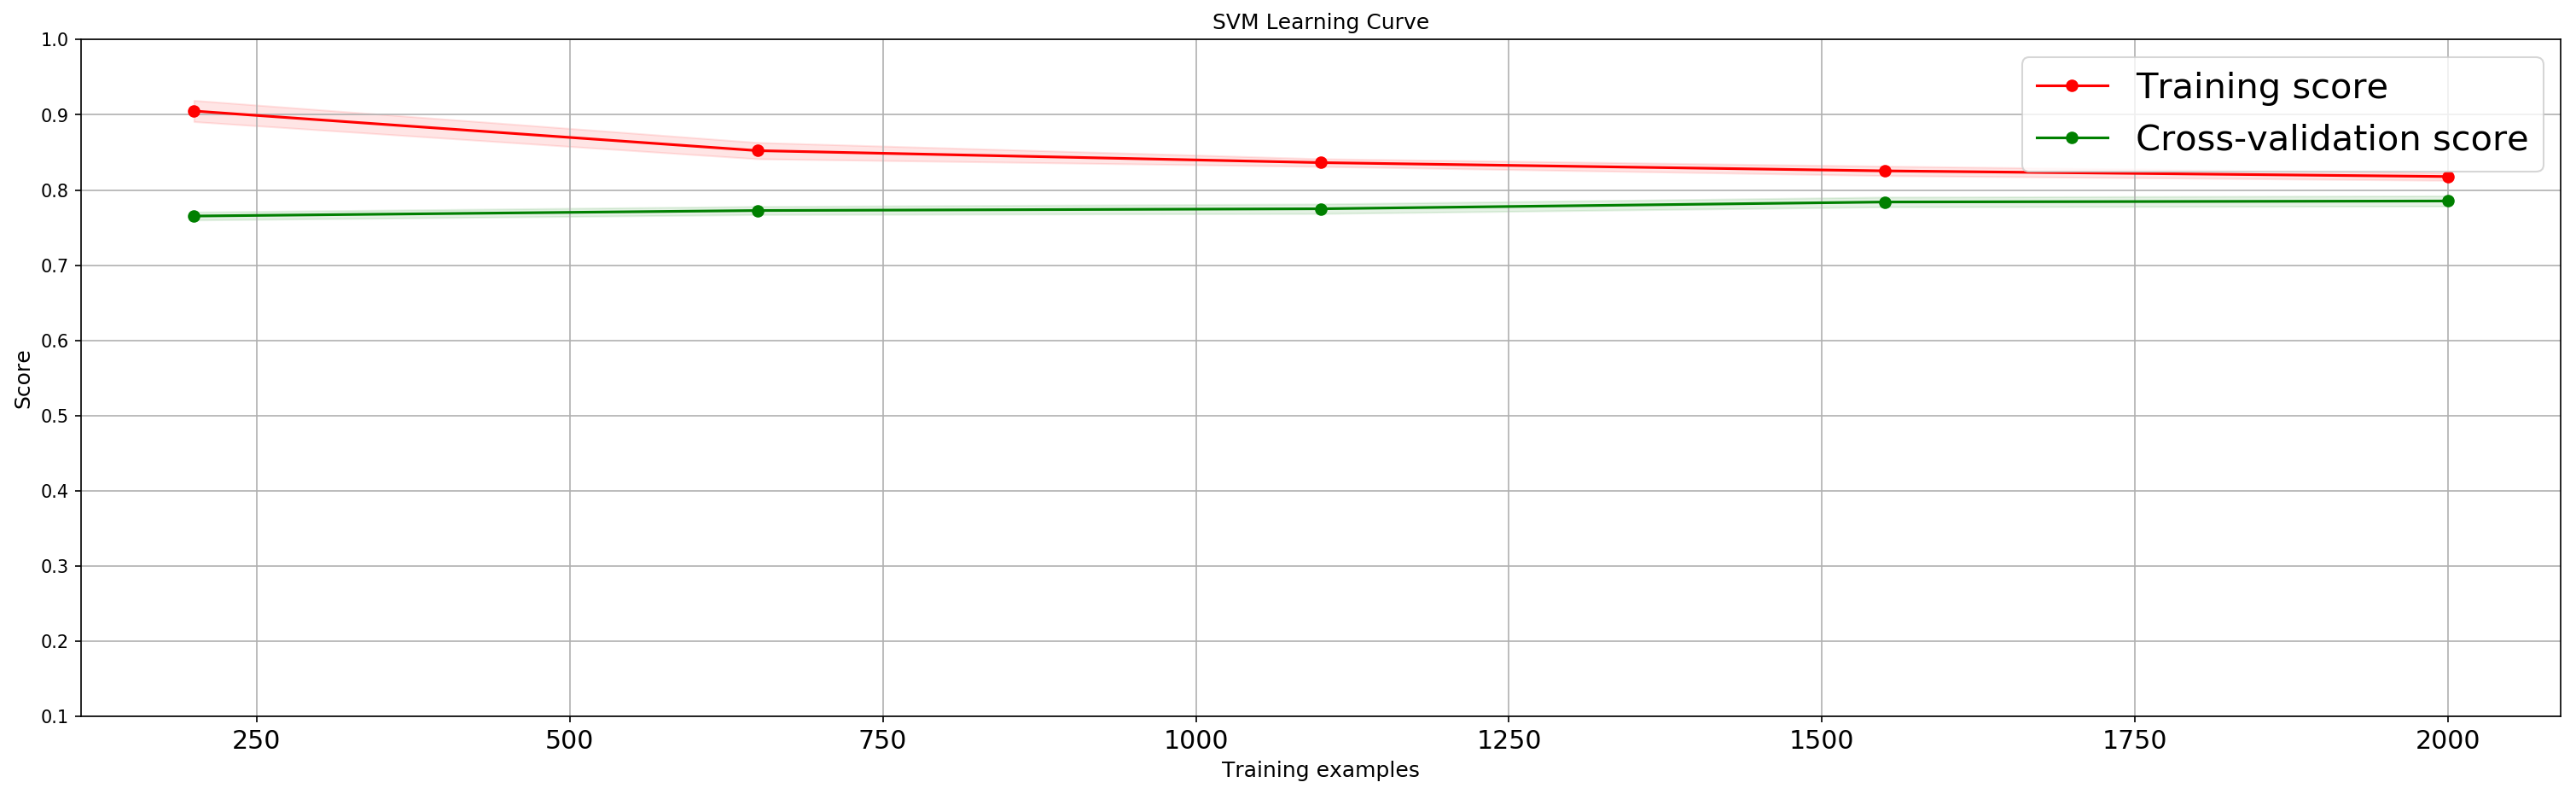

In [39]:
# Learning Curve - Plotting the model's performance on the test set.

plot_learning_curve(svm_clf, "SVM Learning Curve", X_test, y_test, ylim=(0.1, 1.0), cv=3)   

In [40]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_svm_clf)

array([[2127,  147],
       [ 497,  229]])

In [41]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_svm_clf)

0.6090425531914894

In [42]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_svm_clf)

0.3154269972451791

## Logistic Regression Classifier

In [43]:
# Now we train using a Logistic Regression Classifier - A model that generates a probability for each 
# possible discrete label value in classification problems by applying a sigmoid function to a linear prediction.

logit_clf = LogisticRegression(solver = 'lbfgs')

In [44]:
# We time how long it takes to fit the model

start_time = time()
logit_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.02s


In [45]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.78363325, 0.78011144, 0.78654093])

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

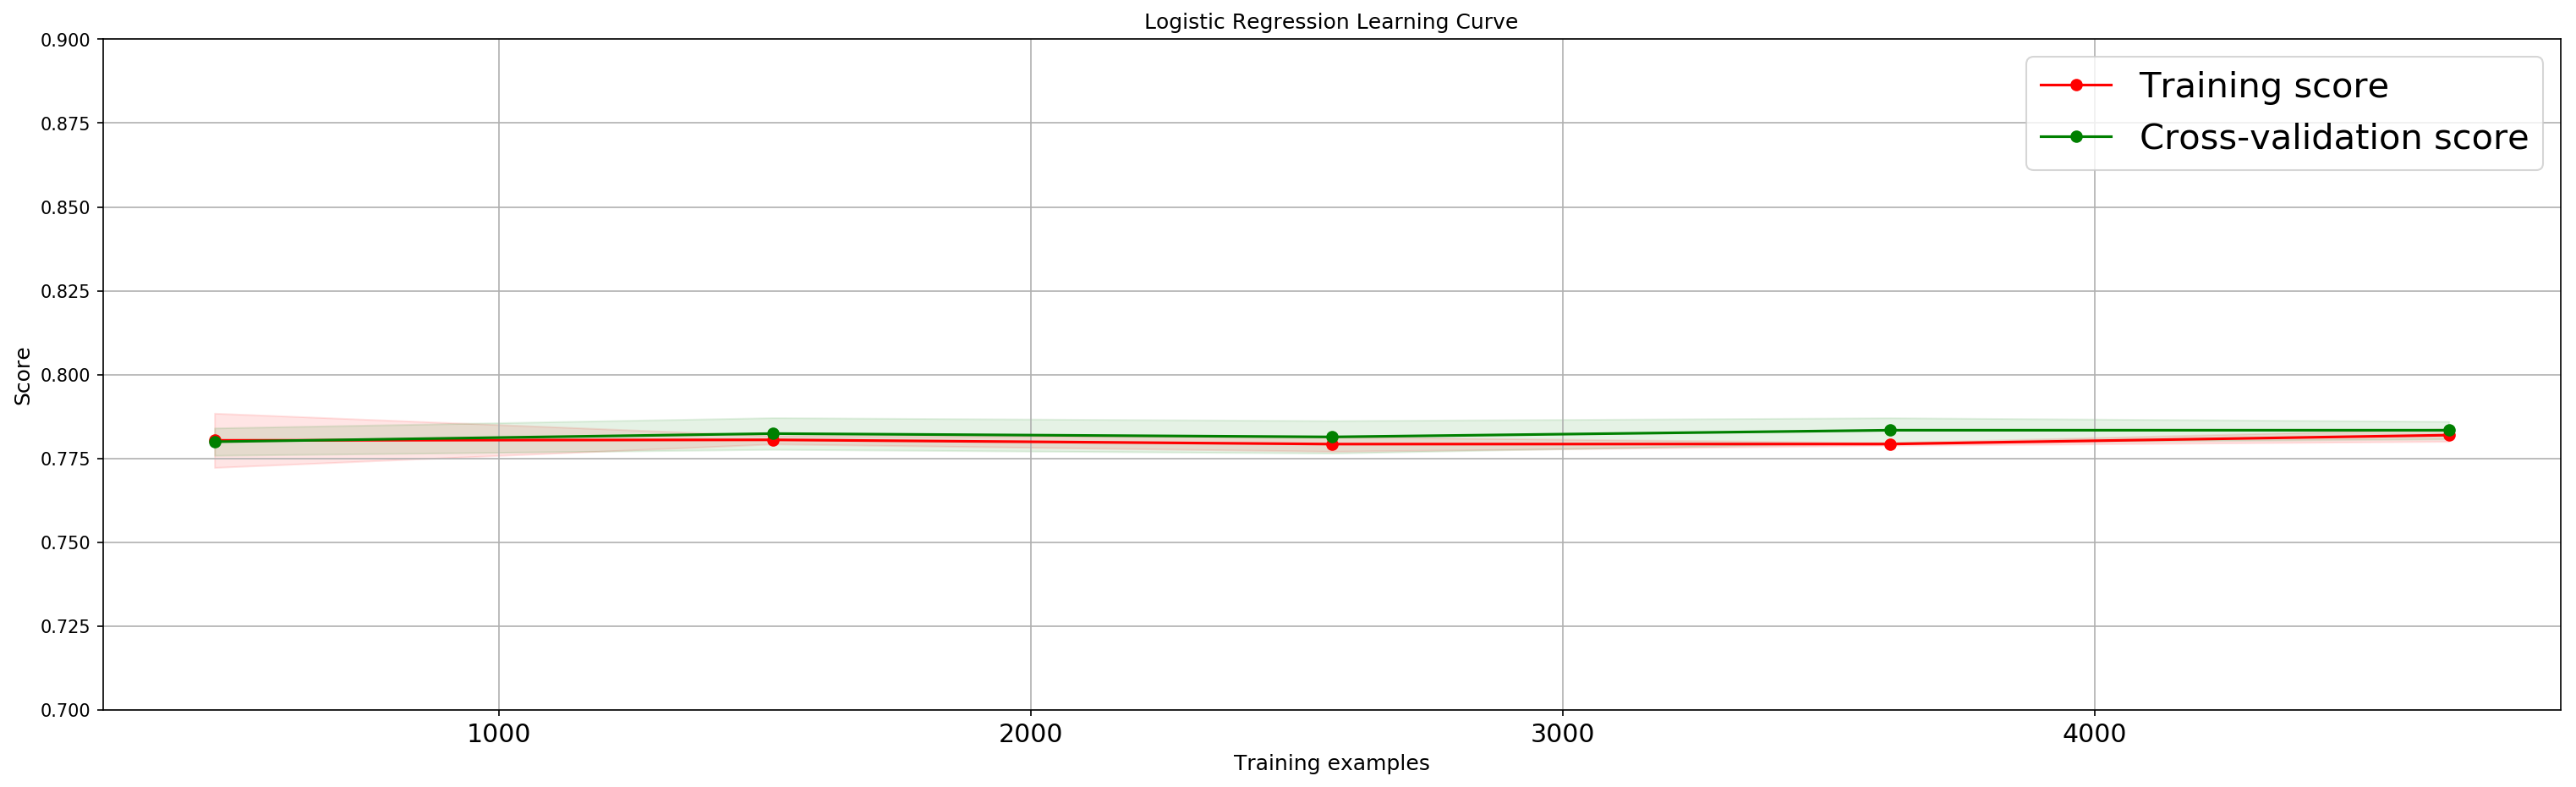

In [46]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(logit_clf, "Logistic Regression Learning Curve", X_train, y_train, ylim=(0.7, 0.9), cv=3)   

In [47]:
y_train_pred_logit_clf = cross_val_predict(logit_clf, X_train, y_train, cv=3)

In [48]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_train, y_train_pred_logit_clf)

array([[5014,  306],
       [1210,  470]])

In [49]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="precision")

array([0.59581882, 0.59437751, 0.62916667])

In [50]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="recall")

array([0.30535714, 0.26428571, 0.26964286])

## Test Data

In [51]:
y_pred_logit_clf = logit_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

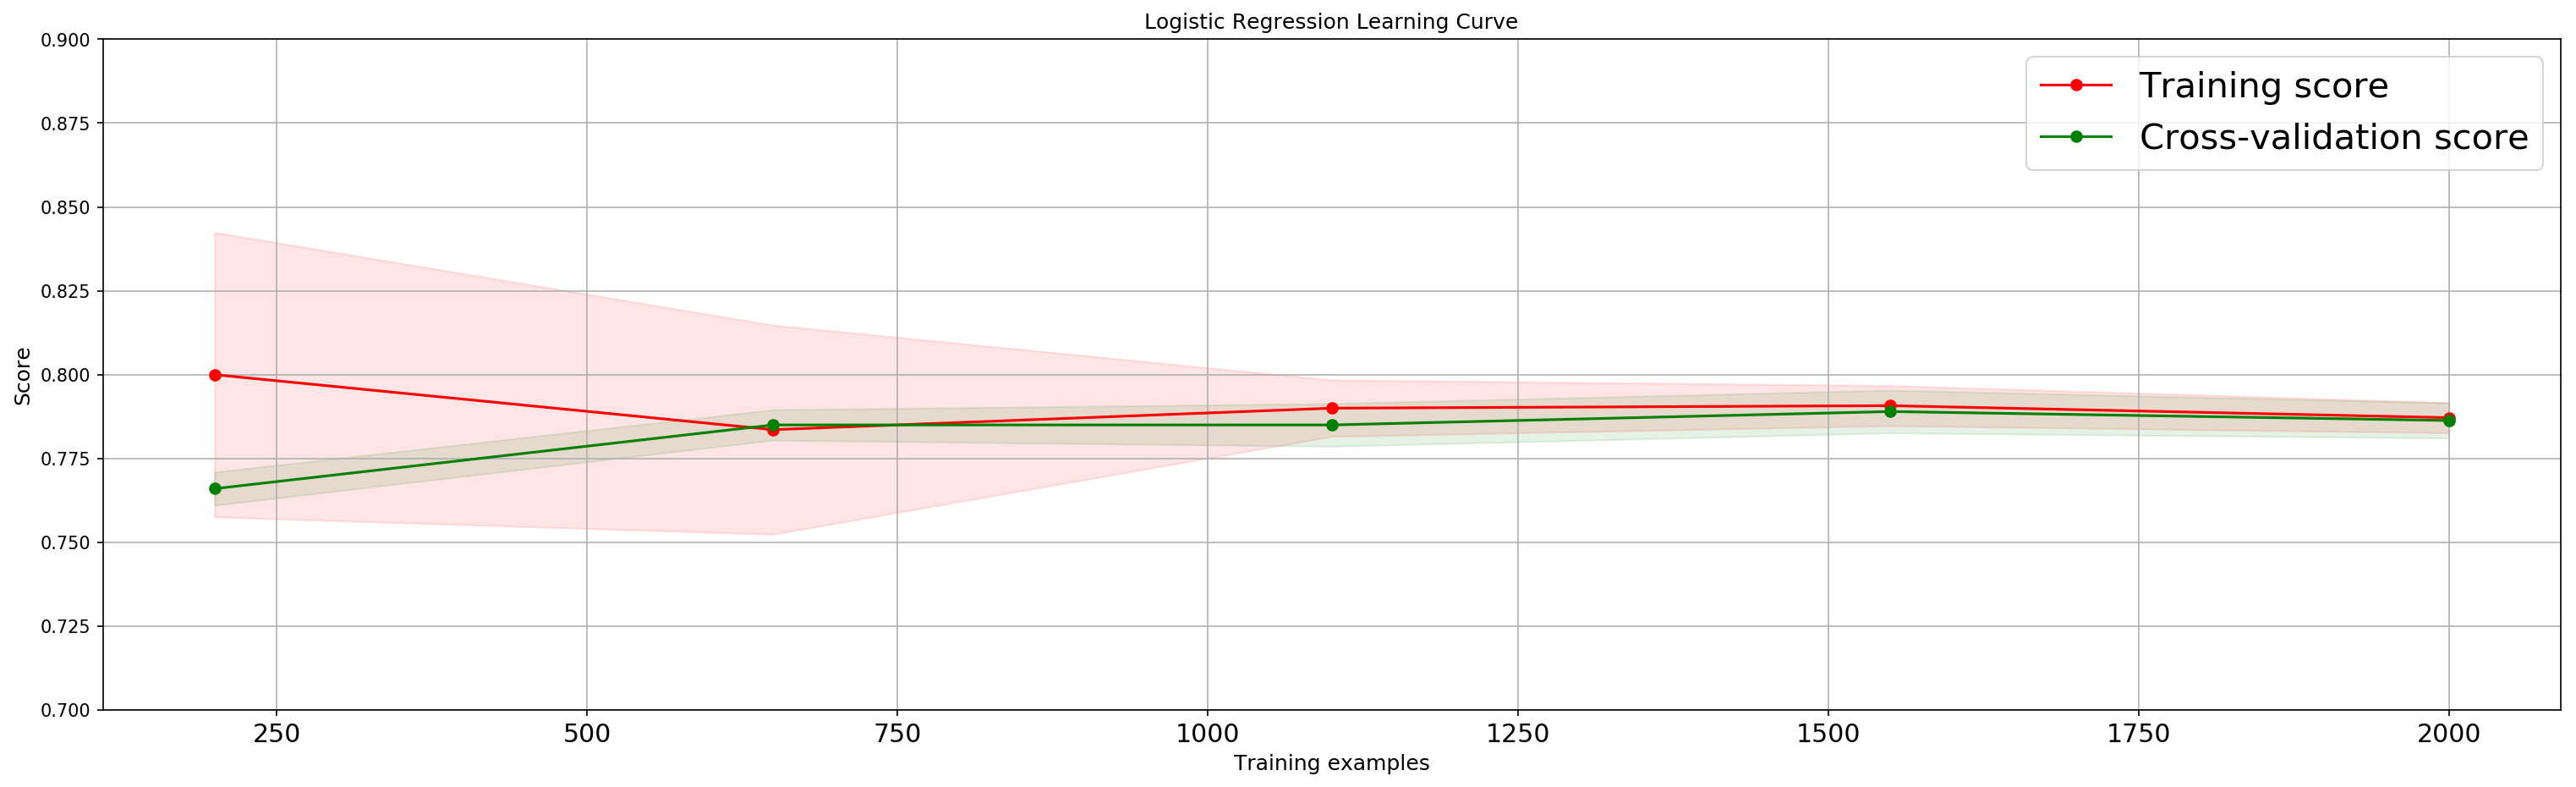

In [52]:
# Learning Curve - Plotting the model's performance on the test set.

plot_learning_curve(logit_clf, "Logistic Regression Learning Curve", X_test, y_test, ylim=(0.7, 0.9), cv=3)   

In [53]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives (Prediction Negative and False), True Positives (Prediciton Positive and True)
# True Negatives (Prediction Negative and True), False Positives (Prediction Positive and False)

confusion_matrix(y_test, y_pred_logit_clf)

array([[2150,  124],
       [ 513,  213]])

In [54]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_logit_clf)

0.6320474777448071

In [55]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_logit_clf)

0.29338842975206614

# Sex vs Salary

In [56]:
# drop columns won't be useful in analysis and prediction
data_sex = data.drop(['fnlwgt', 'education-num', 'education', 
                      'race', 'native-country', 'workclass',
                      'age', 'occupation', 'capital-gain', 'capital-loss',
                      'hours-per-week'], axis=1)

### Decreasing the sample size `n=1000` for ease of use

In [57]:
data_sex = data_sex.sample(n=10000)
data_sex.shape

(10000, 4)

In [58]:
data_sex.head()

,marital-status,relationship,sex,salary
17276,Married-civ-spouse,Husband,Male,1
28306,Never-married,Not-in-family,Male,0
20793,Married-civ-spouse,Husband,Male,0
17512,Married-civ-spouse,Husband,Male,1
27476,Married-civ-spouse,Husband,Male,0


In [59]:
data_sex.tail()

,marital-status,relationship,sex,salary
7819,Never-married,Not-in-family,Female,0
4685,Never-married,Own-child,Male,0
15007,Married-civ-spouse,Husband,Male,0
14022,Never-married,Not-in-family,Male,0
19557,Never-married,Not-in-family,Male,0


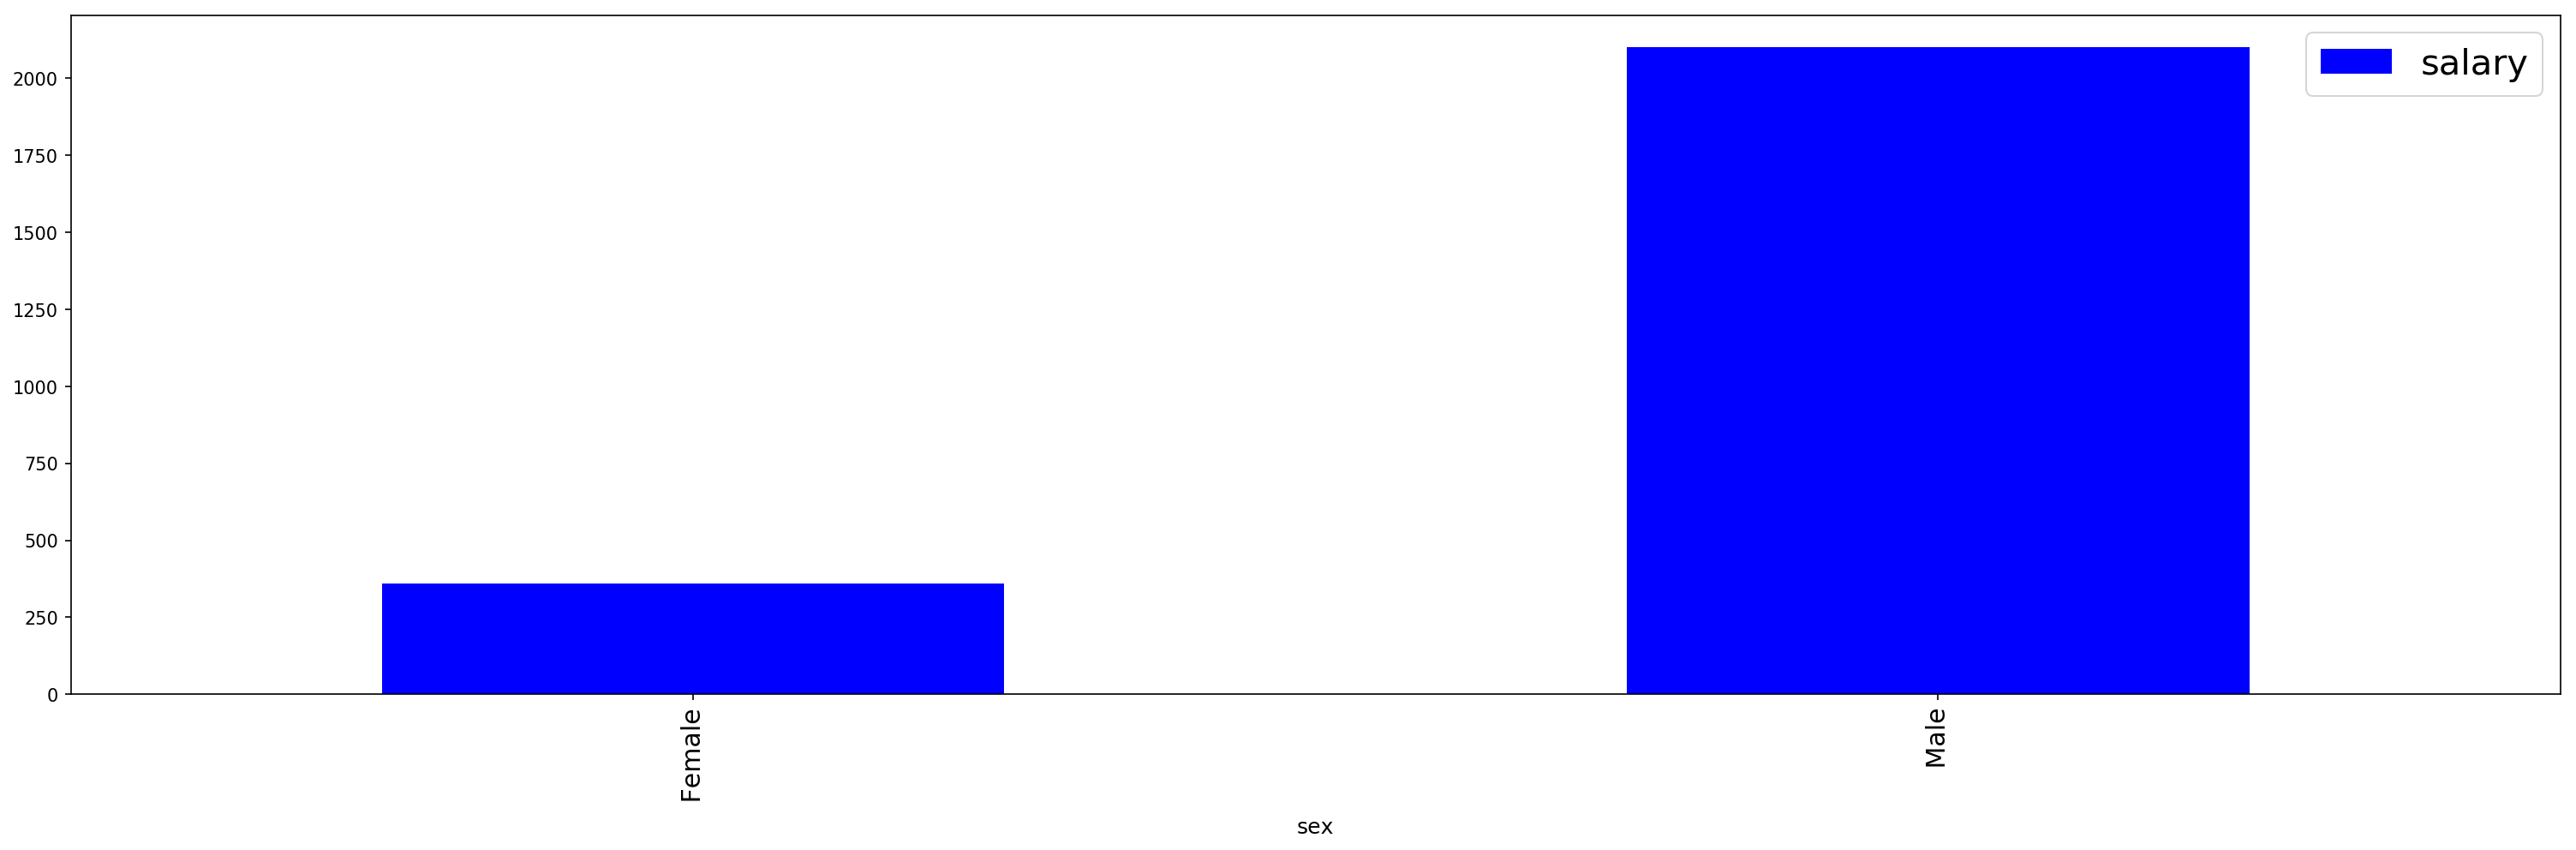

In [60]:
data_sex.groupby('sex').agg('sum')[['salary']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r']);

In [61]:
data_sex["sex"].value_counts()

 Male      6700
 Female    3300
Name: sex, dtype: int64

### apply 1-hot encoding to categorical feature `Sex` 

In [62]:
data_sex.dtypes

marital-status    object
relationship      object
sex               object
salary             int64
dtype: object

In [63]:
data_sex.columns

Index(['marital-status', 'relationship', 'sex', 'salary'], dtype='object')

In [64]:
data_sex = pd.get_dummies(data_sex, columns=['sex'], prefix = ['sex'])

In [65]:
data_sex.dtypes

marital-status    object
relationship      object
salary             int64
sex_ Female        uint8
sex_ Male          uint8
dtype: object

In [66]:
data_sex.describe()

,salary,sex_ Female,sex_ Male
count,10000.000000,10000.000000,10000.000000
mean,0.245800,0.330000,0.670000
std,0.430582,0.470236,0.470236
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


## Train data

In [67]:
data_sex.shape

(10000, 5)

In [68]:
X_train = data_education.iloc[:7000]
X_train = X_train.drop(['salary'], axis=1)

X_test = data_education.iloc[7000:]
X_test = X_test.drop(['salary'], axis=1)

y_train = data_education.iloc[:7000]
y_train = y_train['salary']

y_test = data_education.iloc[7000:]
y_test = y_test['salary']

## Scale the data

In [69]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Linear SVC and Learning Curve

In [70]:
# imports
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.model_selection import KFold

In [71]:
size = 1000
cv = KFold(size, shuffle=True)

In [72]:
X = np.reshape(np.random.normal(scale=2,size=size),(-1,1))
X.shape

(1000, 1)

In [73]:
# np.random.normal(scale=2,size=size) creates a 1000 x 1 matrix
# scale=2 is the standard deviation of the distribution
np.random.normal(scale=2,size=size).shape

(1000,)

In [74]:
y = np.array([[1 - 2*x[0] +x[0]**2] for x in X])
y.shape

(1000, 1)

## Plot learning curve

In [75]:
def plot_curve():
    lg = LinearRegression()

    # fit
    lg.fit(X, y)
    
    """
    Generate a simple plot of the test and traning learning curve.

    """
    
    train_sizes, train_scores, test_scores = learning_curve(lg, X, y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("RandomForestClassifier")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
  
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

No handles with labels found to put in legend.


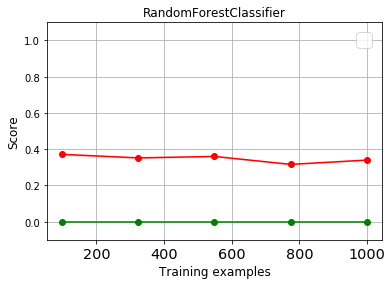

In [76]:
%matplotlib inline
plot_curve()

In [78]:
svc_clf_1 = LinearSVC()
svc_clf_1.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [79]:
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="accuracy")
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="recall")
cross_val_score(svc_clf_1, X_train, y_train, cv=3, scoring="precision")

array([0.58870968, 0.59615385, 0.66666667])

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

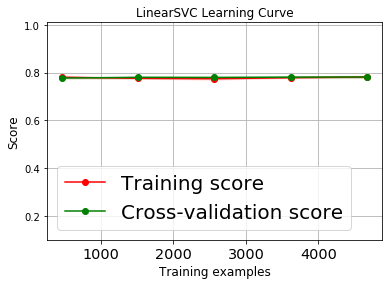

In [80]:
plot_learning_curve(svc_clf_1, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.1, 1.01), cv=3)   

## Random Forest

In [81]:
clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }


acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.797
